# Buy when price is low, sell when price is high

In [14]:
#getting data

from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt

In [4]:
startDate = '2014-01-01'
endDate = '2021-01-01'
googData = data.DataReader('GOOG', 'yahoo', startDate, endDate)
print(googData)

                   High          Low         Open        Close     Volume  \
Date                                                                        
2013-12-31   558.406982   551.064453   554.043335   558.262512  2725979.0   
2014-01-02   556.788025   552.060730   555.647278   554.481689  3656454.0   
2014-01-03   556.379578   550.401978   555.418152   550.436829  3345894.0   
2014-01-06   557.340942   551.154114   554.426880   556.573853  3551864.0   
2014-01-07   567.717041   558.486633   560.399475   567.303589  5124336.0   
...                 ...          ...          ...          ...        ...   
2020-12-24  1746.000000  1729.109985  1735.000000  1738.849976   346800.0   
2020-12-28  1790.728027  1746.334961  1751.635010  1776.089966  1393000.0   
2020-12-29  1792.439941  1756.089966  1787.790039  1758.719971  1299400.0   
2020-12-30  1765.094971  1725.599976  1762.010010  1739.520020  1306100.0   
2020-12-31  1758.930054  1735.420044  1735.420044  1751.880005  1011900.0   

# Preparing data - signal

need to decide when to trade using a signal. This signal may use a large variety of inputes: market information, news or social networking website.

Here, lets calculate the difference in the adj close price between two consecutive days. If value of the adjusted close is negative, the price on the previous day was higher so we can buy since the price is lower now.
If this value is positive, we can sell since the price is higher.

In [5]:
import pandas as pd

googDataSignal = pd.DataFrame(index = googData.index)
googDataSignal['price'] = googData['Adj Close']
googDataSignal['DailyDifference'] = googDataSignal['price'].diff()
googDataSignal.head()

,price,DailyDifference
Date,,
2013-12-31,558.262512,NaN
2014-01-02,554.481689,-3.780823
2014-01-03,550.436829,-4.044861
2014-01-06,556.573853,6.137024
2014-01-07,567.303589,10.729736


In [10]:
googDataSignal['signal'] = 0
googDataSignal['signal'] = np.where(googDataSignal['DailyDifference'] > 0, 1, 0)
googDataSignal.head()

,price,DailyDifference,signal
Date,,,
2013-12-31,558.262512,NaN,0
2014-01-02,554.481689,-3.780823,0
2014-01-03,550.436829,-4.044861,0
2014-01-06,556.573853,6.137024,1
2014-01-07,567.303589,10.729736,1


here, we have 0 where we need to buy, 1 when we have to sell. But we dont want to constantly buy if the market keeps moving down or constantly sell if the market is moving up. we limit the number of orders by restricting the number of positions in the market.

We make it impossible to buy or sell more than one time consecutively. thus, we apply diff to the signal:

In [13]:
googDataSignal['positions'] = googDataSignal['signal'].diff()
googDataSignal[1:10]

,price,DailyDifference,signal,positions
Date,,,,
2014-01-02,554.481689,-3.780823,0,0.0
2014-01-03,550.436829,-4.044861,0,0.0
2014-01-06,556.573853,6.137024,1,1.0
2014-01-07,567.303589,10.729736,1,0.0
2014-01-08,568.484192,1.180603,1,0.0
2014-01-09,563.009705,-5.474487,0,-1.0
2014-01-10,562.979797,-0.029907,0,0.0
2014-01-13,559.393250,-3.586548,0,0.0
2014-01-14,572.553955,13.160706,1,1.0


Thus, we buy one share of GOOG on 6 Jan 2014 at 556.57, and sell one share of GOOG on 9 Jan 2014, at 563.01

# Signal Visualisation

/Users/sonakshirohra/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/sonakshirohra/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/sonakshirohra/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/sonakshirohra/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning

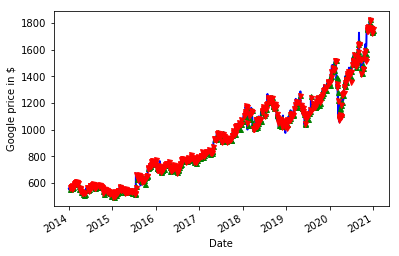

In [30]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel = 'Google price in $')

googDataSignal['price'].plot(ax=ax1, color = 'blue', lw = 2.)
ax1.plot(googDataSignal.loc[googDataSignal.positions == 1.0].index, googDataSignal.price[googDataSignal.positions == 1.0], '^', markersize=5, color = 'g')
ax1.plot(googDataSignal.loc[googDataSignal.positions == -1.0].index, googDataSignal.price[googDataSignal.positions == -1.0], 'v', markersize=5, color = 'r')

# Backtesting

provide statistics that are important, such as:
* Profit and loss (without transact fee)
* Net profit and loss (with transact fee)
* Exposure: capital invested
* no of trades: placed during a trading sessions
* Annualised return
* Sharpe ratio

In [33]:
initialCapital = float(1000.00)

positions = pd.DataFrame(index=googDataSignal.index).fillna(0.0)
portfolio = pd.DataFrame(index=googDataSignal.index).fillna(0.0)

positions['GOOG'] = googDataSignal['signal']
portfolio['positions'] = (positions.multiply(googDataSignal['price'], axis = 0))

portfolio.head()

,positions
Date,
2013-12-31,0.000000
2014-01-02,0.000000
2014-01-03,0.000000
2014-01-06,556.573853
2014-01-07,567.303589


In [37]:
portfolio['cash'] = initialCapital - (positions.diff().multiply(googDataSignal['price'], axis = 0)).cumsum()
portfolio['total'] = portfolio['positions'] + portfolio['cash']

In [38]:
portfolio[1:10]

,positions,cash,total
Date,,,
2014-01-02,0.000000,1000.000000,1000.000000
2014-01-03,0.000000,1000.000000,1000.000000
2014-01-06,556.573853,443.426147,1000.000000
2014-01-07,567.303589,443.426147,1010.729736
2014-01-08,568.484192,443.426147,1011.910339
2014-01-09,0.000000,1006.435852,1006.435852
2014-01-10,0.000000,1006.435852,1006.435852
2014-01-13,0.000000,1006.435852,1006.435852
2014-01-14,572.553955,433.881897,1006.435852
